# Cross Validation for Regression Models

When deciding between various different candidate models, we often use **cross-validation**, which is a way to get a good estimate of each model's performance prior to the final evaluation on the held-out test data. The general process is as follows:

1. Split the data into K folds: K for training, K-1 for validation
2. Train the model(s) on K-1 folds
3. Evaluate the model on the Kth fold using whichever evaluation metrics necessary
4. Compare and contrast model performance
5. Test the model on the test data to get a final out-of-sample estimate of model performance.

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import seaborn as sns

## Generate Dummy Dataset for Regression

Below, we will generate a simple dummy dataset for regression, and split it into training and test data.

In [2]:
from sklearn.datasets import make_regression

# Generate test dataset and format for easy viewing
X, y = make_regression(n_samples = 1000, n_features = 15, n_informative = 10, noise = 50)
dataset = pd.DataFrame(X).add_prefix('x_')
dataset['y'] = y
dataset.head(3)

,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,x_11,x_12,x_13,x_14,y
0,1.433708,-0.572543,-2.001231,-0.421051,0.361555,-0.752007,-0.250720,-0.187602,0.740077,1.403831,-1.066540,0.050043,0.930569,-0.625462,-0.919971,89.416163
1,0.539845,-2.287595,-0.995615,0.642086,0.037617,0.759813,-2.718099,0.796010,-0.671009,-0.180394,-0.852881,-0.223992,0.324445,0.331743,1.231836,54.225045
2,1.296940,1.933954,-0.729785,-0.961836,-1.304575,-0.741713,-1.077827,-1.311417,-0.382706,-2.353837,0.483458,2.083864,0.152018,-0.239103,0.742955,131.360174


### Generate Training Data

Below, we create a very simple pipeline and train the linear model on the sample training data. We will then generate the feature importances using the **training data** only.

Note that in a real workflow, you will likely have to ensure that the dataset conforms to the Linear Regression model requirements. This involves generating dummy variables for categorical data, scaling the data, imputing, etc. Only some of those steps are included below.

In [3]:
# Create training, test splits using 80-20
X = dataset.drop(['y'], axis='columns')
y = dataset['y']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1
)

print('Training Data Size: ', X_train.shape)
print('Test Data Size: ', X_test.shape)

Training Data Size:  (800, 15)
Test Data Size:  (200, 15)


# Model Development

To start off, we can train a few candidate models and understand how the basic non-tuned models perform on the test data. Some of the models we'll be evaluating are:

1. Linear Regression
2. LASSO
4. Random Forest Regressor

In [4]:
# Import pipeline, CV and pre-processing functions
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import time

# Import relevant models
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor

# Import score metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

## Create Pipelines for Each Model

First, we will define specific pipelines for each model we want to train, as each model may have different pre-processing steps we want to apply. By utilizing pipelines, we can easily add/remove specific pre-processing steps without having to re-write larger chunks of code.

In [5]:
# Create a list of pipelines
linearregression = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='mean'),
                                               StandardScaler(with_mean=False),
                                               LinearRegression())
lasso = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='mean'),
                                               StandardScaler(with_mean=False),
                                               Lasso())
randomforest = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='mean'),
                                                       RandomForestRegressor())

# Structure the models dictionary to contain both the pipeline, as well as the results of CV
models = {
    "Linear Regression": {"pipeline": linearregression, 
                          "results": {"cv": "", "test": ""}},
    "Lasso": {"pipeline": lasso,
              "results": {"cv": "", "test": ""}},
    "Random Forest": {"pipeline": randomforest,
                      "results": {"cv": "", "test": ""}}
}

## Train Models with Cross-Validation

Below, we will use 10-fold cross-validate on each model to get an evaluation of their performance. Then, we will generate an out-of-sample test set RMSE to get a final estimate of model performance.

In [6]:
print("Beginning Model Training\n" + "*" * 60)
for name, data in models.items():
    # Extract Pipeline
    model = data['pipeline']
    
    print(f'{name}')
    start = time.time()
    
    # Cross-validate the models
    scores = cross_validate(model,
                            X_train,
                            y_train,
                            cv=10, 
                            scoring=['r2', 'neg_root_mean_squared_error', 'neg_mean_absolute_error'],
                            n_jobs = 2) # Use 2 CPUs, can adjust based on your machine
    stop = time.time()
    
    # Now evaluate model performance on held-out test data
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    # Save results to dictionary (mean of each of the 10 splits for each metric)
    models[name]["results"]["cv"] = { "mean_" + k: round(abs(scores[k].mean()), 4) if k in ["test_neg_mean_absolute_error", "test_neg_root_mean_squared_error"] else round(scores[k].mean(), 4) for k in scores }
    models[name]["results"]["test"] = {"mae": round(abs(mean_absolute_error(y_test, preds)), 4),
                                       "rmse": round(abs(mean_squared_error(y_test, preds, squared=False)), 4),
                                       "r2": round(r2_score(y_test, preds), 4)
                                      }
    # Print relevant information
    print(f'Completed in {round(stop - start, 4)}s ({models[name]["results"]["cv"]["mean_fit_time"]}s per split)')
    print(f'Cross Validation: MAE: {models[name]["results"]["cv"]["mean_test_neg_mean_absolute_error"]} | RMSE: {models[name]["results"]["cv"]["mean_test_neg_root_mean_squared_error"]} | R2: {models[name]["results"]["cv"]["mean_test_r2"]}')
    print(f'Test Data Score : MAE: {models[name]["results"]["test"]["mae"]} | RMSE: {models[name]["results"]["test"]["rmse"]} | R2: {models[name]["results"]["test"]["r2"]}')
    print('*' * 60)

Beginning Model Training
************************************************************
Linear Regression
Completed in 1.49s (0.0109s per split)
Cross Validation: MAE: 40.4471 | RMSE: 50.6647 | R2: 0.9248
Test Data Score : MAE: 40.3197 | RMSE: 49.0498 | R2: 0.9378
************************************************************
Lasso
Completed in 0.0699s (0.0067s per split)
Cross Validation: MAE: 40.3593 | RMSE: 50.4692 | R2: 0.9254
Test Data Score : MAE: 40.3405 | RMSE: 48.8601 | R2: 0.9383
************************************************************
Random Forest
Completed in 2.8794s (0.5508s per split)
Cross Validation: MAE: 73.1524 | RMSE: 93.2149 | R2: 0.7491
Test Data Score : MAE: 80.8846 | RMSE: 100.9067 | R2: 0.7368
************************************************************


We can convert these results from dictionary into dataframes for easier viewing/manipulation.

In [7]:
df_cv_results = pd.DataFrame.from_dict({name: models[name]["results"]["cv"] for name in models}, orient='index')
df_test_results = pd.DataFrame.from_dict({name: models[name]["results"]["test"] for name in models}, orient='index')
df_cv_results

,mean_fit_time,mean_score_time,mean_test_r2,mean_test_neg_root_mean_squared_error,mean_test_neg_mean_absolute_error
Linear Regression,0.0109,0.0038,0.9248,50.6647,40.4471
Lasso,0.0067,0.0037,0.9254,50.4692,40.3593
Random Forest,0.5508,0.0127,0.7491,93.2149,73.1524


## Visualize Results

Now that we have have trained the models and evaluated performance on the test data, we can see that the overall best-performing model is actually the **LASSO** model, as it has the lowest test and CV RMSE out of all three models, as well as the highest R2. With hyperparameter tuning, we can expect the the performance of each model to improve with various magnitudes, but hyperparameter tuning is covered in another notebook.

We can visualize the cross-validation performance of the different models (using MAE and RMSE) using the chunk below.

<Figure size 1200x800 with 0 Axes>

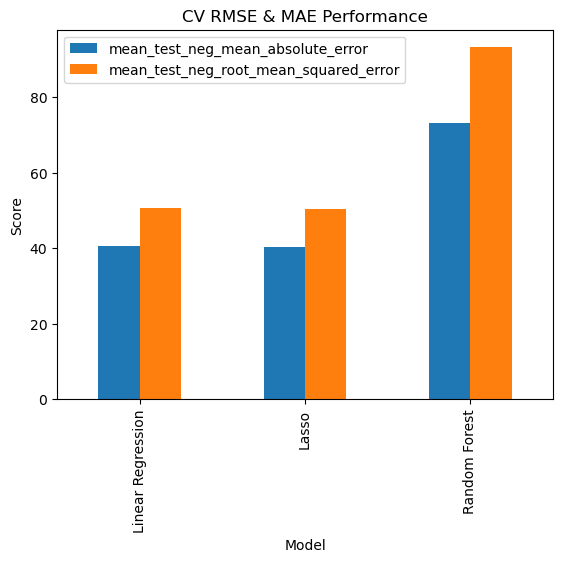

In [8]:
plt.figure(figsize=(12, 8))
ax = df_cv_results[['mean_test_neg_mean_absolute_error', 'mean_test_neg_root_mean_squared_error']].plot(kind="bar")
ax.set_title("CV RMSE & MAE Performance")
ax.set_xlabel("Model")
ax.set_ylabel("Score")

plt.show()